In [2]:
import os
import cv2 
import numpy as np
import rasterio

from matplotlib import pyplot as plt 


In [3]:
impaths = sorted([f"images/{f}" for f in os.listdir("images") if ".jpeg" in f and "_T34VEJ_" in f], key=lambda k: k.split("_")[6])

In [4]:
impaths

['images/Sentinel2_S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE_true_color_base.jpeg',
 'images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T34VEJ_20230608T112304.SAFE_true_color_base.jpeg']

In [5]:
images = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in impaths]


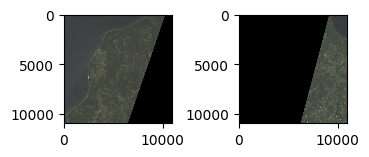

In [6]:
ct = 1
for i in images:
    plt.subplot(3, 3, ct)
    plt.imshow(i)  
    ct += 1

plt.show()


In [7]:
# B04 and B08 for calculating NDVI => ((B08-B04)/(B08+B04))
# NDVI > 7 indicates presence of forest
#
# SCL for working out if what we're seeing is a cloud
# discard if SCL includes ones of invalid = [
#     0, // NO_DATA
#     1, // SATURATED_DEFECTIVE
#     3, // CLOUD_SHADOW
#     7, // CLOUD_LOW_PROBA
#     8, // CLOUD_MEDIUM_PROBA
#     9, // CLOUD_HIGH_PROBA
#     10 // THIN_CIRRUS
# ]

In [8]:
# T34VEJ_20230608T093549_SCL_20m
# T34VEJ_20230609T100031_SCL_20m
# T34VEJ_20230611T094549_SCL_20m

In [9]:
scl = rasterio.open("data/T34VEJ_20230608T093549_SCL_20m.jp2", driver="JP2OpenJPEG").read(1)

In [10]:
scl

array([[0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 6, 6, 6],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4],
       [0, 0, 0, ..., 4, 4, 4]], shape=(5490, 5490), dtype=uint8)

In [11]:
list(set([f.split("_")[6] for f in os.listdir("images") if ".jpeg" in f]))

['T34VFK',
 'T34VEK',
 'T35ULB',
 'T35VNC',
 'T34VEJ',
 'T34UDG',
 'T34UEG',
 'T35VLD',
 'T35VNE',
 'T34VEH',
 'T35VLE',
 'T35VME',
 'T34VDH',
 'T34VFJ',
 'T35VMD',
 'T34VDK']

In [12]:
# -32768 NODATA

In [13]:
#function getFirstQuartileValue(values) {
#    values.sort((a,b) => a-b);
#    return getFirstQuartile(values);
#}
#
#function getFirstQuartile(sortedValues) {
#    var index = Math.floor(sortedValues.length / 4);
#    return sortedValues[index];
#}

In [14]:
files = {}
for f in os.listdir("data"):
    if ".jp2" in f and "T34VEJ_" in f:
        parts = f.split("_")
        if parts[1] not in files:
            files[parts[1]] = {}
        files[parts[1]][parts[2]] = f"data/{f}"


In [15]:
files


{'20230609T100031': {'B04': 'data/T34VEJ_20230609T100031_B04_10m.jp2',
  'SCL': 'data/T34VEJ_20230609T100031_SCL_20m.jp2',
  'B02': 'data/T34VEJ_20230609T100031_B02_10m.jp2',
  'B03': 'data/T34VEJ_20230609T100031_B03_10m.jp2',
  'B08': 'data/T34VEJ_20230609T100031_B08_10m.jp2'},
 '20230608T093549': {'B08': 'data/T34VEJ_20230608T093549_B08_10m.jp2',
  'B03': 'data/T34VEJ_20230608T093549_B03_10m.jp2',
  'SCL': 'data/T34VEJ_20230608T093549_SCL_20m.jp2',
  'B02': 'data/T34VEJ_20230608T093549_B02_10m.jp2',
  'B04': 'data/T34VEJ_20230608T093549_B04_10m.jp2'},
 '20230611T094549': {'B04': 'data/T34VEJ_20230611T094549_B04_10m.jp2',
  'B08': 'data/T34VEJ_20230611T094549_B08_10m.jp2',
  'B02': 'data/T34VEJ_20230611T094549_B02_10m.jp2',
  'SCL': 'data/T34VEJ_20230611T094549_SCL_20m.jp2',
  'B03': 'data/T34VEJ_20230611T094549_B03_10m.jp2'}}

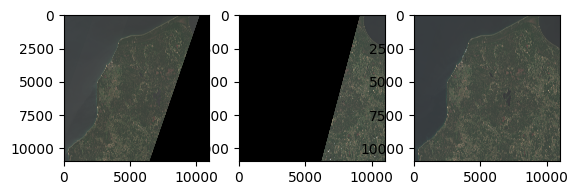

In [16]:
gain = 2

ct = 1
for f in files.values():
    plt.subplot(1, 3, ct)

    red = np.clip(rasterio.open(f["B04"], driver="JP2OpenJPEG").read(1) * gain / 10000, 0, 1)
    green = np.clip(rasterio.open(f["B03"], driver="JP2OpenJPEG").read(1) * gain / 10000, 0, 1)
    blue = np.clip(rasterio.open(f["B02"], driver="JP2OpenJPEG").read(1) * gain / 10000, 0, 1)
    rgb_composite = np.dstack((red, green, blue))
    
    plt.imshow(rgb_composite)
    ct += 1

plt.show()


In [17]:
invalid = [
    0, # NO_DATA
    1, # SATURATED_DEFECTIVE
    3, # CLOUD_SHADOW
    7, # CLOUD_LOW_PROBA
    8, # CLOUD_MEDIUM_PROBA
    9, # CLOUD_HIGH_PROBA
    10 # THIN_CIRRUS
]

red = np.full((10980, 10980), -32768)
green = np.full((10980, 10980), -32768)
blue = np.full((10980, 10980), -32768)

for f in files.values():
    scl = np.repeat(np.repeat(rasterio.open(f["SCL"], driver="JP2OpenJPEG").read(1), 2, 0), 2, 1)
    
    c_red = rasterio.open(f["B04"], driver="JP2OpenJPEG").read(1)
    c_green = rasterio.open(f["B03"], driver="JP2OpenJPEG").read(1)
    c_blue = rasterio.open(f["B02"], driver="JP2OpenJPEG").read(1)

    mask = ((scl != 0) & (scl != 1) & (scl != 3) & (scl != 7) & (scl != 8) & (scl != 9) & (scl != 10))
    red[mask] = c_red[mask]
    green[mask] = c_green[mask]
    blue[mask] = c_blue[mask]


In [18]:
gain = 2

rgb_composite = np.dstack((
    np.clip(red * gain / 10000, 0, 1), 
    np.clip(green * gain / 10000, 0, 1), 
    np.clip(blue * gain / 10000, 0, 1)
))

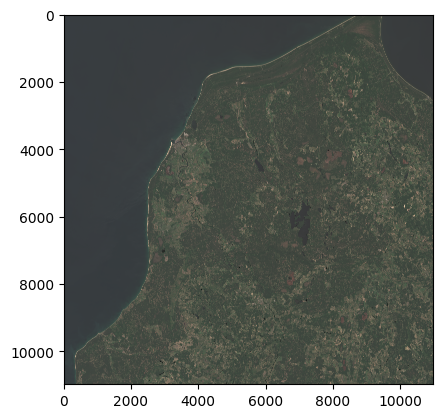

In [19]:
plt.imshow(rgb_composite)

In [20]:
scl = np.full((5490, 5490), -32768)


In [21]:
blue

array([[1273, 1286, 1273, ..., 1186, 1194, 1193],
       [1265, 1269, 1265, ..., 1190, 1190, 1168],
       [1265, 1268, 1270, ..., 1176, 1181, 1167],
       ...,
       [1271, 1280, 1284, ..., 1276, 1264, 1269],
       [1298, 1283, 1283, ..., 1288, 1296, 1284],
       [1294, 1275, 1263, ..., 1312, 1284, 1290]], shape=(10980, 10980))

In [22]:
np.repeat(np.repeat(scl, 2, 0), 2, 1)

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]],
      shape=(10980, 10980))

In [23]:
files = {}
for f in os.listdir("data"):
    if ".jp2" in f:
        parts = f.split("_")
        if parts[0] not in files:
            files[parts[0]] = {}
        if parts[1] not in files[parts[0]]:
            files[parts[0]][parts[1]] = {}
        files[parts[0]][parts[1]][parts[2]] = f"data/{f}"


In [24]:
files

{'T34UEG': {'20230608T093549': {'B02': 'data/T34UEG_20230608T093549_B02_10m.jp2',
   'SCL': 'data/T34UEG_20230608T093549_SCL_20m.jp2',
   'B03': 'data/T34UEG_20230608T093549_B03_10m.jp2',
   'B08': 'data/T34UEG_20230608T093549_B08_10m.jp2',
   'B04': 'data/T34UEG_20230608T093549_B04_10m.jp2'},
  '20230606T095031': {'B08': 'data/T34UEG_20230606T095031_B08_10m.jp2',
   'SCL': 'data/T34UEG_20230606T095031_SCL_20m.jp2',
   'B02': 'data/T34UEG_20230606T095031_B02_10m.jp2',
   'B03': 'data/T34UEG_20230606T095031_B03_10m.jp2',
   'B04': 'data/T34UEG_20230606T095031_B04_10m.jp2'}},
 'T35VME': {'20230613T094041': {'B08': 'data/T35VME_20230613T094041_B08_10m.jp2',
   'B02': 'data/T35VME_20230613T094041_B02_10m.jp2',
   'SCL': 'data/T35VME_20230613T094041_SCL_20m.jp2',
   'B03': 'data/T35VME_20230613T094041_B03_10m.jp2',
   'B04': 'data/T35VME_20230613T094041_B04_10m.jp2'},
  '20230608T093549': {'B08': 'data/T35VME_20230608T093549_B08_10m.jp2',
   'B03': 'data/T35VME_20230608T093549_B03_10m.jp2',

In [26]:
files.keys()

dict_keys(['T34UEG', 'T35VME', 'T35VMD', 'T34VFK', 'T34VFJ', 'T35VND', 'T35VNE', 'T34VDK', 'T34UDG', 'T35VNC', 'T34VEK', 'T35ULB', 'T34UFG', 'T34VEH', 'T34VDH', 'T34VEJ', 'T35VLD', 'T35VLE'])

In [ ]:
gain = 2

order = [
    'T34UEG', 
    'T34UDG', 
    'T35VME', 
    'T35VMD', 
    'T34VEJ', 
    'T34VFJ', 
    'T34VFK', 
    'T35VND', 
    'T35VNE', 
    'T34VDK', 
    'T35VNC', 
    'T34VEK', 
    'T35ULB', 
    'T34UFG', 
    'T34VEH', 
    'T34VDH', 
    'T35VLD', 
    'T35VLE'
]

ct = 1
for ki, fi in files.items():
    fi = files[ki]
    if ct > 13:
        break # kernel dies on macbook
    print(ct, ki)
    plt.subplot(4, 4, ct, title=ki)

    red = np.full((10980, 10980), -32768)
    green = np.full((10980, 10980), -32768)
    blue = np.full((10980, 10980), -32768)
    
    for fj in fi.values():
        scl = np.repeat(np.repeat(rasterio.open(fj["SCL"], driver="JP2OpenJPEG").read(1), 2, 0), 2, 1)
        
        c_red = rasterio.open(fj["B04"], driver="JP2OpenJPEG").read(1)
        c_green = rasterio.open(fj["B03"], driver="JP2OpenJPEG").read(1)
        c_blue = rasterio.open(fj["B02"], driver="JP2OpenJPEG").read(1)
    
        mask = ((scl != 0) & (scl != 1) & (scl != 3) & (scl != 7) & (scl != 8) & (scl != 9) & (scl != 10))
        red[mask] = c_red[mask]
        green[mask] = c_green[mask]
        blue[mask] = c_blue[mask]

    rgb_composite = np.dstack((
        np.clip(red * gain / 10000, 0, 1), 
        np.clip(green * gain / 10000, 0, 1), 
        np.clip(blue * gain / 10000, 0, 1)
    ))
    plt.imshow(rgb_composite)
    ct += 1

plt.show()


1 T34UEG
2 T35VME
